##### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2022 Semester 1

## Assignment 2: Sentiment Classification of Tweets

This is a sample code to assist you with vectorising the 'Train' dataset for your assignment 2.

First we read the CSV datafiles (Train and Test).

In [36]:
import re
import time

import matplotlib.pyplot as plt
import numpy as np
# import libraries
import pandas as pd
import seaborn as sns
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier


In [37]:
# read data from csv file
train_data = pd.read_csv("Train.csv", sep=',')
test_data = pd.read_csv("Test.csv", sep=',')

### Text Preprocessing

In [38]:


#separating instance and label for Train
X_train_raw = [x[0] for x in train_data[['text']].values]
Y_train = [x[0] for x in train_data[['sentiment']].values]

In [39]:
# data cleaning
X_train_raw = train_data['text'].apply(lambda x: re.sub(r'http\S+', '', x))
X_train_raw = X_train_raw.apply(lambda x: re.sub(r'@[A-Za-z0-9]+', '', x))

X_test_raw = test_data['text'].apply(lambda x: re.sub(r'http\S+', '', x))
X_test_raw = X_test_raw.apply(lambda x: re.sub(r'@[A-Za-z0-9]+', '', x))

#check the result
print("Test length:", len(X_test_raw))

Test length: 6099


### Training test splitting

In [53]:
# hold out with test size 0.3
X_train, X_test, y_train, y_test = train_test_split(X_train_raw, Y_train,
                                                    test_size=0.3,
                                                    random_state=30)

In [55]:
# BoW applied on testing data, training data and develop data
BoW_vectorizer = CountVectorizer()
X_train_BoW = BoW_vectorizer.fit_transform(X_train_raw)
X_test_BoW = BoW_vectorizer.transform(X_test_raw)
x_train_BoW = BoW_vectorizer.fit_transform(X_train)
x_test_BoW = BoW_vectorizer.transform(X_test)

In [ ]:
# fit into linear models
models = [DummyClassifier(strategy='most_frequent'),
          MultinomialNB(),
          LinearSVC(),
          DecisionTreeClassifier(),
          KNeighborsClassifier(),
          LogisticRegression()]
titles = ['Zero-R',
          'MNB',
          'LinearSVC',
          'Decision Tree',
          'KNN',
          'Logistic Regression']

for title, model in zip(titles, models):
    start = time.time()
    model.fit(x_train_BoW.todense(), y_train)
    end = time.time()
    t = end - start
    acc = model.score(x_test_BoW.todense(), y_test)
    print(title, "Accuracy:", acc, 'Time:', t)

Zero-R Accuracy: 0.5882892524078887 Time: 0.5542497634887695


/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


MNB Accuracy: 0.6584620088671457 Time: 15.972088098526001


/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


LinearSVC Accuracy: 0.6284971716862865 Time: 8.288585901260376


/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


### Feature selecting

In [13]:
# Tfidf Vectorizer
vectorizer = TfidfVectorizer()
tf_x_train = vectorizer.fit_transform(X_train)
tf_x_test = vectorizer.transform(X_test)

lr = LogisticRegression(C=1).fit(tf_x_train, y_train)
for c in [0.01, 0.05, 0.25, 0.5, 1]:
    lr = LogisticRegression(C=c)
    lr.fit(tf_x_train, y_train)
    print("Accuracy for C=%s: %s"
          % (c, accuracy_score(y_test, lr.predict(tf_x_test))))

mnb = MultinomialNB().fit(tf_x_train, y_train)
print(mnb.score(tf_x_test, y_test))

clf = LinearSVC(random_state=0)
clf.fit(tf_x_train, y_train)
print(clf.score(tf_x_test, y_test))


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy for C=0.01: 0.5882892524078887
Accuracy for C=0.05: 0.6057177801559395
Accuracy for C=0.25: 0.6480660449472557


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy for C=0.5: 0.6648830454059013


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy for C=1: 0.6748203638587372
0.6015899709524537
0.6627426998929827


In [42]:
vectorizer = TfidfVectorizer()
tf_X_train = vectorizer.fit_transform(X_train_raw)
tf_X_test = vectorizer.transform(X_test_raw)

model_lr = LogisticRegression(multi_class='ovr')
model_lr.fit(tf_X_train, Y_train)

prediction = model_lr.predict(tf_X_test.todense())
pre = pd.DataFrame(prediction, columns=['sentiment'], index=test_data['id'])
pre.index.name = 'id'
pre.to_csv(r"tfidf_prediction_cv.csv")

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [43]:
# apply k best on tfidf 
kbest = SelectKBest(chi2, k=500).fit(tf_x_train, y_train)
kbest_train_x = kbest.transform(tf_x_train)
kbest_test_x = kbest.transform(tf_x_test)

mnb = MultinomialNB().fit(kbest_train_x, y_train)
print(mnb.score(kbest_test_x, y_test))

clf = LinearSVC(random_state=0)
clf.fit(kbest_train_x, y_train)
print(clf.score(kbest_test_x, y_test))

final_tfidf = LogisticRegression(C=1)
final_tfidf.fit(kbest_train_x, y_train)
print(final_tfidf.score(kbest_test_x, y_test))

0.607399480201804
0.6725271365234674
0.6595321816236049


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [44]:
# save the created vocabulary for the given dataset in a separate file
vocab_dict = BoW_vectorizer.vocabulary_
output_pd = pd.DataFrame(list(vocab_dict.items()), columns=['word', 'count'])
output_pd.T.to_csv('BoW-vocab.csv', index=False)

In [45]:
# apply k best on BoW 
kbest = SelectKBest(chi2, k=500).fit(X_train_BoW, Y_train)
kbest_train_X = kbest.transform(X_train_BoW)
kbest_test_X = kbest.transform(X_test_BoW)

# training dataset
kbest = SelectKBest(chi2, k=700).fit(x_train_BoW, y_train)
kbest_train_x = kbest.transform(x_train_BoW)
kbest_test_x = kbest.transform(x_test_BoW)

In [46]:
# training and development set
x_train = kbest_train_x
x_test = kbest_test_x
# training and testing set
X_train = kbest_train_X
X_test = kbest_test_X

### Model Adapting

In [23]:
# Use the 10_fold_Cross_Validation with 4 models(LinearSVC, Decision Tree, KNN, Logistic Regression)
models = [LinearSVC(),
          DecisionTreeClassifier(),
          KNeighborsClassifier(),
          LogisticRegression()]
titles = ['LinearSVC',
          'Decision Tree',
          'KNN',
          'Logistic Regression']

for title, model in zip(titles, models):
    start = time.time()
    acc = np.mean(cross_val_score(model, x_train, y_train, cv=20))
    end = time.time()
    t = end - start
    print(title, "Accuracy:", acc, 'time:', t)

for title, model in zip(titles, models):
    start = time.time()
    acc = np.mean(cross_val_score(model, x_test, y_test, cv=20))
    end = time.time()
    t = end - start
    print(title, "Accuracy:", acc, 'time:', t)

/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warning

LinearSVC Accuracy: 0.6865215839926442 time: 37.43350410461426
Decision Tree Accuracy: 0.5624781278090755 time: 16.788177967071533
KNN Accuracy: 0.585020293962246 time: 5.297817945480347


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Logistic Regression Accuracy: 0.6838343923476495 time: 8.189378023147583


/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC Accuracy: 0.6633540314760945 time: 12.372828006744385
Decision Tree Accuracy: 0.5470169501006936 time: 4.587082147598267
KNN Accuracy: 0.5872202953680913 time: 1.164933681488037


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Logistic Regression Accuracy: 0.6679402550906245 time: 5.3771021366119385


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Parameter Tuning

## LinearSVC

In [47]:
from sklearn.model_selection import validation_curve

param_range = np.logspace(-2, 2, 10)
train_scores, valid_scores = validation_curve(LinearSVC(), x_train, y_train,
                                              param_name='C',
                                              param_range=param_range, cv=5,
                                              n_jobs=-1, verbose=10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  50 | elapsed:    8.9s remaining:  2.3min
[Parallel(n_jobs=-1)]: Done   9 out of  50 | elapsed:    8.9s remaining:   40.6s
[Parallel(n_jobs=-1)]: Done  15 out of  50 | elapsed:    8.9s remaining:   20.8s
[Parallel(n_jobs=-1)]: Done  21 out of  50 | elapsed:    8.9s remaining:   12.3s
[Parallel(n_jobs=-1)]: Done  27 out of  50 | elapsed:    8.9s remaining:    7.6s
[Parallel(n_jobs=-1)]: Done  33 out of  50 | elapsed:    8.9s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done  39 out of  50 | elapsed:    8.9s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  45 out of  50 | elapsed:    8.9s remaining:    1.0s

KeyboardInterrupt



In [48]:
mean_train_scores = np.mean(train_scores, axis=1)
std_train_scores = np.std(train_scores, axis=1)
mean_valid_scores = np.mean(valid_scores, axis=1)
std_valid_scores = np.std(valid_scores, axis=1)

NameError: name 'train_scores' is not defined

In [51]:
plt.semilogx(param_range, mean_train_scores, label="Training score",
             color='red')
plt.fill_between(param_range, mean_train_scores - std_train_scores,
                 mean_train_scores + std_train_scores, alpha=0.2, color="red")

plt.semilogx(param_range, mean_valid_scores, label="cross validation score",
             color='blue')
plt.fill_between(param_range, mean_valid_scores - std_valid_scores,
                 mean_valid_scores + std_valid_scores, alpha=0.2, color="blue")

plt.legend(loc='best')
plt.title("Validation curve for hyperparameter C in LinearSVC")
plt.xlabel("C in log scale")
plt.ylabel("Accuracy")
plt.show()

best_C = param_range[mean_valid_scores.argmax()]
best_C

NameError: name 'mean_train_scores' is not defined

## rbf SVC

In [57]:
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

parameters = {'kernel': ['rbf'], 'gamma': [1e-2, 1e-3, 1e-4, 1e-5],
              "C": [10, 100, 1000, 10000]}

grd = GridSearchCV(estimator=SVC(), param_grid=parameters, n_jobs=-1, cv=3)

grd.fit(x_train, y_train)
print(grd.best_params_)

#
svc_rbf = SVC(kernel="rbf", gamma=0.001, C=1000).fit(x_train, y_train)
print(grd.best_score_)
print(svc_rbf.score(x_train, y_train))
print(svc_rbf.score(x_train, y_test))
print(classification_report(y_test, svc_rbf.predict(x_train)))



KeyboardInterrupt



In [59]:
# Instantiate SVC

param_range = np.logspace(-2, 2, 10)
train_scores_rbf, valid_scores_rbf = validation_curve(
    SVC(max_iter=10000),
    x_train,
    y_train,
    param_name='C',
    param_range=param_range,
    cv=3,
    n_jobs=-1, verbose=10)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:  1.4min remaining: 13.0min
[Parallel(n_jobs=-1)]: Done   7 out of  30 | elapsed:  1.5min remaining:  4.8min
[Parallel(n_jobs=-1)]: Done  11 out of  30 | elapsed:  1.5min remaining:  2.5min
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:  1.5min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:  2.6min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:  2.6min remaining:   48.1s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:  2.6min remaining:   17.6s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.7min finished


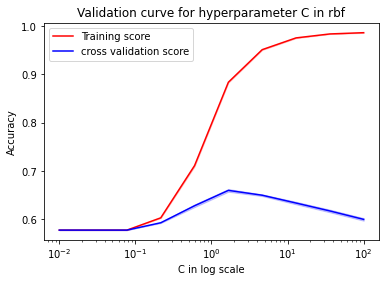

1.6681005372000592


In [62]:

# Graphing helper

def val_curve(param_range, train_scores, valid_scores, model_name):
    mean_train_scores = np.mean(train_scores, axis=1)
    std_train_scores = np.std(train_scores, axis=1)
    mean_valid_scores = np.mean(valid_scores, axis=1)
    std_valid_scores = np.std(valid_scores, axis=1)
    plt.semilogx(param_range, mean_train_scores, label="Training score",
                 color='red')
    plt.fill_between(param_range, mean_train_scores - std_train_scores,
                     mean_train_scores + std_train_scores, alpha=0.2,
                     color="red")

    plt.semilogx(param_range, mean_valid_scores,
                 label="cross validation score",
                 color='blue')
    plt.fill_between(param_range, mean_valid_scores - std_valid_scores,
                     mean_valid_scores + std_valid_scores, alpha=0.2,
                     color="blue")

    plt.legend(loc='best')
    plt.title(f"Validation curve for hyperparameter C in {model_name}")
    plt.xlabel("C in log scale")
    plt.ylabel("Accuracy")
    plt.show()
    best_C = param_range[mean_valid_scores.argmax()]
    print(best_C)


val_curve(param_range, train_scores_rbf, valid_scores_rbf, "rbf")

In [65]:

# Random Forests

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

parameters = {"n_estimators": [10, 25, 50, 75, 100, 150, 200],
              "max_depth": [10, 25, 50, 75, 100, 150, 200],
              "criterion": ["entropy", "gini"],
              }
grd = GridSearchCV(estimator=RandomForestClassifier(random_state=1, n_jobs=-1),
                   param_grid=parameters, n_jobs=-1, cv=3)
grd.fit(x_train, y_train)
print(grd.best_params_)


{'criterion': 'gini', 'max_depth': 10, 'n_estimators': 10}


In [67]:

## Instantiate Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

random_forest = RandomForestClassifier(
    random_state=1,
    n_jobs=-1,
    criterion="gini",
    max_depth=75,
    n_estimators=150).fit(x_train, y_train)

print(random_forest.score(x_train, y_train))
print(random_forest.score(x_test, y_test))
print(classification_report(y_test, random_forest.predict(x_test)))








0.8600353843129546
0.6488304540590124
              precision    recall  f1-score   support

    negative       0.66      0.12      0.21      1099
     neutral       0.64      0.92      0.76      3848
    positive       0.68      0.36      0.47      1594

    accuracy                           0.65      6541
   macro avg       0.66      0.47      0.48      6541
weighted avg       0.65      0.65      0.59      6541



## Logistic Regression

In [38]:
# use grid search find optimal c for logistic regression
from sklearn.model_selection import GridSearchCV

param_lr = {'C': [0.01, 0.1, 0.5, 1, 5, 10, 100],
            'multi_class': ['multinomial', 'ovr'],
            }
gs_lr = GridSearchCV(LogisticRegression(), param_lr, cv=5, n_jobs=1,
                     verbose=11)
print("Performing grid search...")
print("parameters:")
print(param_lr)

gs_lr.fit(x_train, y_train)
print("Best score: 40. 3f" % gs_lr.best_score_)
print("Best parameters set:")

best_param_lr = gs_lr.best_estimator_.get_params()

for param_name in sorted(param_lr.keys()):
    print("\t%s: %r" % (param_name, best_param_lr[param_name]))

Performing grid search...
parameters:
{'C': [0.01, 0.1, 0.5, 1, 5, 10, 100], 'multi_class': ['multinomial', 'ovr']}
Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV 1/5; 1/14] START C=0.01, multi_class=multinomial............................
[CV 1/5; 1/14] END C=0.01, multi_class=multinomial;, score=0.617 total time=   0.2s
[CV 2/5; 1/14] START C=0.01, multi_class=multinomial............................
[CV 2/5; 1/14] END C=0.01, multi_class=multinomial;, score=0.615 total time=   0.1s
[CV 3/5; 1/14] START C=0.01, multi_class=multinomial............................
[CV 3/5; 1/14] END C=0.01, multi_class=multinomial;, score=0.610 total time=   0.1s
[CV 4/5; 1/14] START C=0.01, multi_class=multinomial............................
[CV 4/5; 1/14] END C=0.01, multi_class=multinomial;, score=0.618 total time=   0.1s
[CV 5/5; 1/14] START C=0.01, multi_class=multinomial............................
[CV 5/5; 1/14] END C=0.01, multi_class=multinomial;, score=0.617 total time=   0.1

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5; 5/14] END C=0.5, multi_class=multinomial;, score=0.671 total time=   0.4s
[CV 2/5; 5/14] START C=0.5, multi_class=multinomial.............................


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5; 5/14] END C=0.5, multi_class=multinomial;, score=0.681 total time=   0.4s
[CV 3/5; 5/14] START C=0.5, multi_class=multinomial.............................


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5; 5/14] END C=0.5, multi_class=multinomial;, score=0.674 total time=   0.4s
[CV 4/5; 5/14] START C=0.5, multi_class=multinomial.............................


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5; 5/14] END C=0.5, multi_class=multinomial;, score=0.672 total time=   0.4s
[CV 5/5; 5/14] START C=0.5, multi_class=multinomial.............................


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5; 5/14] END C=0.5, multi_class=multinomial;, score=0.677 total time=   0.4s
[CV 1/5; 6/14] START C=0.5, multi_class=ovr.....................................
[CV 1/5; 6/14] END ......C=0.5, multi_class=ovr;, score=0.664 total time=   0.4s
[CV 2/5; 6/14] START C=0.5, multi_class=ovr.....................................
[CV 2/5; 6/14] END ......C=0.5, multi_class=ovr;, score=0.679 total time=   0.3s
[CV 3/5; 6/14] START C=0.5, multi_class=ovr.....................................
[CV 3/5; 6/14] END ......C=0.5, multi_class=ovr;, score=0.669 total time=   0.3s
[CV 4/5; 6/14] START C=0.5, multi_class=ovr.....................................
[CV 4/5; 6/14] END ......C=0.5, multi_class=ovr;, score=0.672 total time=   0.3s
[CV 5/5; 6/14] START C=0.5, multi_class=ovr.....................................
[CV 5/5; 6/14] END ......C=0.5, multi_class=ovr;, score=0.670 total time=   0.3s
[CV 1/5; 7/14] START C=1, multi_class=multinomial...............................


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5; 7/14] END C=1, multi_class=multinomial;, score=0.675 total time=   0.4s
[CV 2/5; 7/14] START C=1, multi_class=multinomial...............................


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5; 7/14] END C=1, multi_class=multinomial;, score=0.684 total time=   0.4s
[CV 3/5; 7/14] START C=1, multi_class=multinomial...............................


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5; 7/14] END C=1, multi_class=multinomial;, score=0.675 total time=   0.4s
[CV 4/5; 7/14] START C=1, multi_class=multinomial...............................


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5; 7/14] END C=1, multi_class=multinomial;, score=0.682 total time=   0.4s
[CV 5/5; 7/14] START C=1, multi_class=multinomial...............................


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV 5/5; 7/14] END C=1, multi_class=multinomial;, score=0.681 total time=   0.4s
[CV 1/5; 8/14] START C=1, multi_class=ovr.......................................


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV 1/5; 8/14] END ........C=1, multi_class=ovr;, score=0.669 total time=   0.4s
[CV 2/5; 8/14] START C=1, multi_class=ovr.......................................


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV 2/5; 8/14] END ........C=1, multi_class=ovr;, score=0.684 total time=   0.4s
[CV 3/5; 8/14] START C=1, multi_class=ovr.......................................


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV 3/5; 8/14] END ........C=1, multi_class=ovr;, score=0.674 total time=   0.4s
[CV 4/5; 8/14] START C=1, multi_class=ovr.......................................


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV 4/5; 8/14] END ........C=1, multi_class=ovr;, score=0.674 total time=   0.4s
[CV 5/5; 8/14] START C=1, multi_class=ovr.......................................


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV 5/5; 8/14] END ........C=1, multi_class=ovr;, score=0.672 total time=   0.4s
[CV 1/5; 9/14] START C=5, multi_class=multinomial...............................


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5; 9/14] END C=5, multi_class=multinomial;, score=0.680 total time=   0.4s
[CV 2/5; 9/14] START C=5, multi_class=multinomial...............................


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5; 9/14] END C=5, multi_class=multinomial;, score=0.694 total time=   0.4s
[CV 3/5; 9/14] START C=5, multi_class=multinomial...............................


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5; 9/14] END C=5, multi_class=multinomial;, score=0.681 total time=   0.4s
[CV 4/5; 9/14] START C=5, multi_class=multinomial...............................


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5; 9/14] END C=5, multi_class=multinomial;, score=0.689 total time=   0.4s
[CV 5/5; 9/14] START C=5, multi_class=multinomial...............................


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV 5/5; 9/14] END C=5, multi_class=multinomial;, score=0.688 total time=   0.4s
[CV 1/5; 10/14] START C=5, multi_class=ovr......................................


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV 1/5; 10/14] END .......C=5, multi_class=ovr;, score=0.678 total time=   0.4s
[CV 2/5; 10/14] START C=5, multi_class=ovr......................................


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV 2/5; 10/14] END .......C=5, multi_class=ovr;, score=0.692 total time=   0.4s
[CV 3/5; 10/14] START C=5, multi_class=ovr......................................


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV 3/5; 10/14] END .......C=5, multi_class=ovr;, score=0.680 total time=   0.4s
[CV 4/5; 10/14] START C=5, multi_class=ovr......................................


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV 4/5; 10/14] END .......C=5, multi_class=ovr;, score=0.679 total time=   0.5s
[CV 5/5; 10/14] START C=5, multi_class=ovr......................................


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV 5/5; 10/14] END .......C=5, multi_class=ovr;, score=0.682 total time=   0.4s
[CV 1/5; 11/14] START C=10, multi_class=multinomial.............................


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5; 11/14] END C=10, multi_class=multinomial;, score=0.680 total time=   0.4s
[CV 2/5; 11/14] START C=10, multi_class=multinomial.............................


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5; 11/14] END C=10, multi_class=multinomial;, score=0.693 total time=   0.4s
[CV 3/5; 11/14] START C=10, multi_class=multinomial.............................


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5; 11/14] END C=10, multi_class=multinomial;, score=0.683 total time=   0.4s
[CV 4/5; 11/14] START C=10, multi_class=multinomial.............................


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5; 11/14] END C=10, multi_class=multinomial;, score=0.688 total time=   0.4s
[CV 5/5; 11/14] START C=10, multi_class=multinomial.............................


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV 5/5; 11/14] END C=10, multi_class=multinomial;, score=0.691 total time=   0.4s
[CV 1/5; 12/14] START C=10, multi_class=ovr.....................................


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV 1/5; 12/14] END ......C=10, multi_class=ovr;, score=0.678 total time=   0.4s
[CV 2/5; 12/14] START C=10, multi_class=ovr.....................................


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV 2/5; 12/14] END ......C=10, multi_class=ovr;, score=0.693 total time=   0.5s
[CV 3/5; 12/14] START C=10, multi_class=ovr.....................................


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV 3/5; 12/14] END ......C=10, multi_class=ovr;, score=0.680 total time=   0.4s
[CV 4/5; 12/14] START C=10, multi_class=ovr.....................................


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV 4/5; 12/14] END ......C=10, multi_class=ovr;, score=0.684 total time=   0.4s
[CV 5/5; 12/14] START C=10, multi_class=ovr.....................................


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV 5/5; 12/14] END ......C=10, multi_class=ovr;, score=0.683 total time=   0.4s
[CV 1/5; 13/14] START C=100, multi_class=multinomial............................


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5; 13/14] END C=100, multi_class=multinomial;, score=0.677 total time=   0.4s
[CV 2/5; 13/14] START C=100, multi_class=multinomial............................


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5; 13/14] END C=100, multi_class=multinomial;, score=0.693 total time=   0.4s
[CV 3/5; 13/14] START C=100, multi_class=multinomial............................


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5; 13/14] END C=100, multi_class=multinomial;, score=0.683 total time=   0.4s
[CV 4/5; 13/14] START C=100, multi_class=multinomial............................


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5; 13/14] END C=100, multi_class=multinomial;, score=0.688 total time=   0.4s
[CV 5/5; 13/14] START C=100, multi_class=multinomial............................


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV 5/5; 13/14] END C=100, multi_class=multinomial;, score=0.691 total time=   0.4s
[CV 1/5; 14/14] START C=100, multi_class=ovr....................................


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV 1/5; 14/14] END .....C=100, multi_class=ovr;, score=0.678 total time=   0.4s
[CV 2/5; 14/14] START C=100, multi_class=ovr....................................


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV 2/5; 14/14] END .....C=100, multi_class=ovr;, score=0.697 total time=   0.4s
[CV 3/5; 14/14] START C=100, multi_class=ovr....................................


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV 3/5; 14/14] END .....C=100, multi_class=ovr;, score=0.682 total time=   0.4s
[CV 4/5; 14/14] START C=100, multi_class=ovr....................................


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV 4/5; 14/14] END .....C=100, multi_class=ovr;, score=0.682 total time=   0.4s
[CV 5/5; 14/14] START C=100, multi_class=ovr....................................


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV 5/5; 14/14] END .....C=100, multi_class=ovr;, score=0.683 total time=   0.4s
Best score: 40. 3f
Best parameters set:
	C: 10
	multi_class: 'multinomial'


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


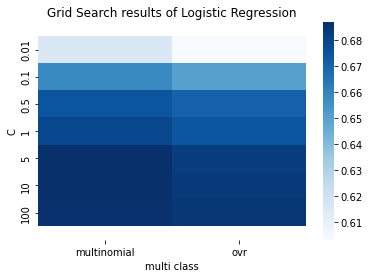

[CV] START C=12.915496650148826.................................................
[CV] END C=12.915496650148826;, score=(train=0.728, test=0.678) total time=   8.4s
[CV] START C=0.01...............................................................
[CV] END ............C=0.01;, score=(train=0.667, test=0.647) total time=   0.2s
[CV] START C=0.027825594022071243...............................................
[CV] END C=0.027825594022071243;, score=(train=0.694, test=0.660) total time=   0.4s
[CV] START C=0.21544346900318834................................................
[CV] END C=0.21544346900318834;, score=(train=0.722, test=0.678) total time=   1.7s
[CV] START C=4.6415888336127775.................................................
[CV] END C=4.6415888336127775;, score=(train=0.728, test=0.679) total time=   7.9s
[CV] START C=35.93813663804626..................................................
[CV] END C=35.93813663804626;, score=(train=0.722, test=0.683) total time=   9.4s
[CV] START C=1.6

In [39]:
lr_scores = gs_lr.cv_results_['mean_test_score'].reshape(7, 2)
sns.heatmap(lr_scores, xticklabels=param_lr['multi_class'],
            yticklabels=param_lr['C'], cmap='Blues')

b, t = plt.ylim()  # discover the values for bottom and top
b += 0.5  # Add 0.5 to the bottom
t -= 0.5  # Subtract 0.5 from the top
plt.ylim(b, t)  # update the ylim(bottom, top) values
plt.title("Grid Search results of Logistic Regression")
plt.xlabel("multi class")
plt.ylabel("C")
plt.show()

              precision    recall  f1-score   support

    negative       0.61      0.34      0.44      1099
     neutral       0.68      0.86      0.76      3848
    positive       0.67      0.45      0.54      1594

    accuracy                           0.67      6541
   macro avg       0.65      0.55      0.58      6541
weighted avg       0.67      0.67      0.65      6541



/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Text(33.0, 0.5, 'Actual classes')

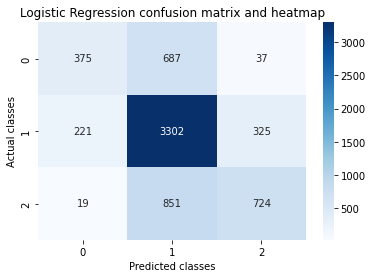

In [30]:
# logistic heatmap
lr = LogisticRegression(C=1).fit(x_train, y_train)
lr_pred = lr.predict(x_test)

matrix_lr = confusion_matrix(y_test, lr_pred)
print(classification_report(y_test, lr_pred))
sns.heatmap(matrix_lr, cmap='Blues', annot=True, fmt='d')
plt.title("Logistic Regression confusion matrix and heatmap")
plt.xlabel("Predicted classes")
plt.ylabel("Actual classes")

### Ensemble models

In [31]:
#voting
base_classifiers = [('sgd', SGDClassifier()),
                    ('dt', DecisionTreeClassifier()),
                    ('lr', LogisticRegression(C=1, multi_class='multinomial')),
                    ('mnb', MultinomialNB()),
                    (' svc', LinearSVC(C=10))]
voting = VotingClassifier(estimators=base_classifiers, voting='hard')
voting.fit(x_train, y_train)
print("voting accuracy")
cross_val_score(voting, x_train, y_train, cv=5).mean(), voting.score(x_test,
                                                                     y_test)


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


voting accuracy


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Pl

(0.6823277192491412, 0.6706925546552515)

In [32]:
# bagging
DT = DecisionTreeClassifier()
bagging_one = BaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                n_estimators=10,
                                max_samples=1.0, max_features=1.0)
bagging_two = BaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                n_estimators=10,
                                max_samples=0.5, max_features=1.0)
bagging_three = BaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                  n_estimators=10,
                                  max_samples=0.5, max_features=0.5)

DT.fit(x_train, y_train)
bagging_one.fit(x_train, y_train)
bagging_two.fit(x_train, y_train)
bagging_three.fit(x_train, y_train)

print("DT:", DT.score(x_test, y_test))
print("Option 1: bagging Accuracy:", bagging_one.score(x_test, y_test))
print("Option 2: bagging Accuracy:", bagging_two.score(x_test, y_test))
print("Option 3: bagging Accuracy:", bagging_three.score(x_test, y_test))

DT: 0.5554196606023544
Option 1: bagging Accuracy: 0.5985323345054273
Option 2: bagging Accuracy: 0.6116801712276411
Option 3: bagging Accuracy: 0.6141262803852622


In [33]:
from sklearn.ensemble import VotingClassifier

#voting
base_classifiers = [('sgd', SGDClassifier()),
                    ('dt', DecisionTreeClassifier()),
                    ('lr',
                     LogisticRegression(C=0.5, multi_class='multinomial')),
                    ('mnb', MultinomialNB()),
                    (' svc', LinearSVC(C=10))]
voting = VotingClassifier(estimators=base_classifiers, voting='hard')

voting.fit(kbest_train_X.todense(), Y_train)

prediction = voting.predict(kbest_test_X.todense())
#print("Stacker predict done")

print(prediction)
pre = pd.DataFrame(prediction, columns=['sentiment'], index=test_data['id'])
pre.index.name = 'id'
pre.to_csv(r"voting_prediction_cv.csv")

/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn

['neutral' 'negative' 'neutral' ... 'neutral' 'neutral' 'negative']


/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


0.6398104265402843


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished


0.6107628802935331
[[ 300  728   71]
 [ 295 3072  481]
 [  53  918  623]]
0.6408805992967436


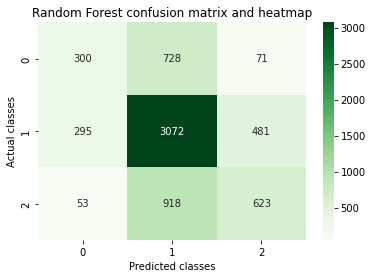

In [34]:
#random forest
rf = RandomForestClassifier(n_jobs=-1, n_estimators=100, verbose=1).fit(
    x_train, y_train)
print(rf.score(x_test, y_test))

rf = RandomForestClassifier(n_jobs=-1, n_estimators=10, verbose=1).fit(x_train,
                                                                       y_train)
print(rf.score(x_test, y_test))

rf_pred = rf.predict(x_test)
matrix_rf = confusion_matrix(y_test, rf_pred)

print(matrix_rf)
sns.heatmap(matrix_rf, cmap='Greens', annot=True, fmt='d')
plt.title("Random Forest confusion matrix and heatmap")
plt.xlabel("Predicted classes")
plt.ylabel("Actual classes")

#ada
ada = AdaBoostClassifier().fit(x_train, y_train)
print(ada.score(x_test, y_test))

In [35]:
# stacking code from prac 8
np.random.seed(1)


class StackingClassifier():

    def __init__(self, classifiers, metaclassifier):
        self.classifiers = classifiers
        self.metaclassifier = metaclassifier

    def fit(self, X, y):
        for clf in self.classifiers:
            clf.fit(X, y)
        X_meta = self._predict_base(X)
        self.metaclassifier.fit(X_meta, y)

    def _predict_base(self, X):
        yhats = []
        for clf in self.classifiers:
            yhat = clf.predict_proba(X)
            yhats.append(yhat)
        yhats = np.concatenate(yhats, axis=1)
        assert yhats.shape[0] == X.shape[0]
        return yhats

    def predict(self, X):
        X_meta = self._predict_base(X)
        yhat = self.metaclassifier.predict(X_meta)
        return yhat

    def score(self, X, y):
        yhat = self.predict(X)
        return accuracy_score(y, yhat)

In [36]:
# base calssifier to be chosen # lr/multinomial
classifiers = [LogisticRegression(),
               MultinomialNB()]
titles = ['Logistic Regression',
          'Multinomial NB']

# three meta classifiers
meta_classifier_lr = LogisticRegression(C=1)
stacker_lr = StackingClassifier(classifiers, meta_classifier_lr)

meta_classifier_mnb = MultinomialNB()
stacker_mnb = StackingClassifier(classifiers, meta_classifier_mnb)

meta_classifier_svc = LinearSVC(C=10)
stacker_svc = StackingClassifier(classifiers, meta_classifier_svc)

In [37]:
start = time.time()
stacker_lr.fit(x_train.todense(), y_train)
end = time.time()
t = end - start
acc_lr = stacker_lr.score(x_test.todense(), y_test)
print('\nStacker Accuracy (Logistic Regression):', acc_lr, 'Time:', t)

start = time.time()
stacker_mnb.fit(x_train.todense(), y_train)
end = time.time()
t = end - start
acc_mnb = stacker_mnb.score(x_test.todense(), y_test)
print('\nStacker Accuracy (Multinomial Regression):', acc_mnb, 'Time:', t)

start = time.time()
stacker_svc.fit(x_train.todense(), y_train)
end = time.time()
t = end - start
acc_svc = stacker_svc.score(x_test.todense(), y_test)
print('\nStacker Accuracy (LinearSVC):', acc_svc, 'Time:', t)


/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please conver


Stacker Accuracy (Logistic Regression): 0.6714569637670081 Time: 2.832603931427002


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please conver


Stacker Accuracy (Multinomial Regression): 0.6709983182999542 Time: 2.6380109786987305


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please conver


Stacker Accuracy (LinearSVC): 0.6713040819446567 Time: 4.609684944152832


/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


### Prediction

In [ ]:
stacker_lr.fit(kbest_train_X.todense(), Y_train)
stacker_svc.fit(kbest_train_X.todense(), Y_train)

prediction = stacker_svc.predict(kbest_test_X.todense())
pre = pd.DataFrame(prediction, columns=['sentiment'], index=test_data['id'])
pre.index.name = 'id'
pre.to_csv(r"svc_stacker_prediction_cv.csv")

prediction = stacker_lr.predict(kbest_test_X.todense())
pre = pd.DataFrame(prediction, columns=['sentiment'], index=test_data['id'])
pre.index.name = 'id'
pre.to_csv(r"lr_stacker_prediction_cv.csv")